In [1]:
import os
import sys
import copy
import json
import time
import shutil

import torch
from torch.autograd import Variable
from torch import optim
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# TODO: Fix sibling directory imports
cwd = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(cwd, '..'))

from src.datautils.sandia import SandiaDataProvider
from src.utils import show_batch_of_images
from src.models import mlp_net as mlp
from src.reasoning_agents import FFNReasoningAgent, RNN_RA
from src.autoencoders import PCA_autoencoder
from src.utils import show_batch_of_images, dict_of_lists_to_list_of_dicts
from src.ra_training import train_reasoning_agent, train_iteration

In [2]:
hyperparams = {
    'img_size': [28],
    'encoding_size': [50],
    'hidden_dim': [200],
    'num_hidden_layers': [1],
    'agent_type': ['rnn'],
    'network_type': ['vanilla'],
    
    'learning_rate': [0.05],
    'momentum': [0.1],
    'weight_decay': [0],
    'num_epochs': [50],
    'batch_size': [64],
    'patience_epochs': [5],
    'nonlinearity': ['relu']
}

1 out of 1:
14.8 seconds: Training stopped after 50 epochs Best val loss: 7.506Best accuracy: 0.381 at epoch 49


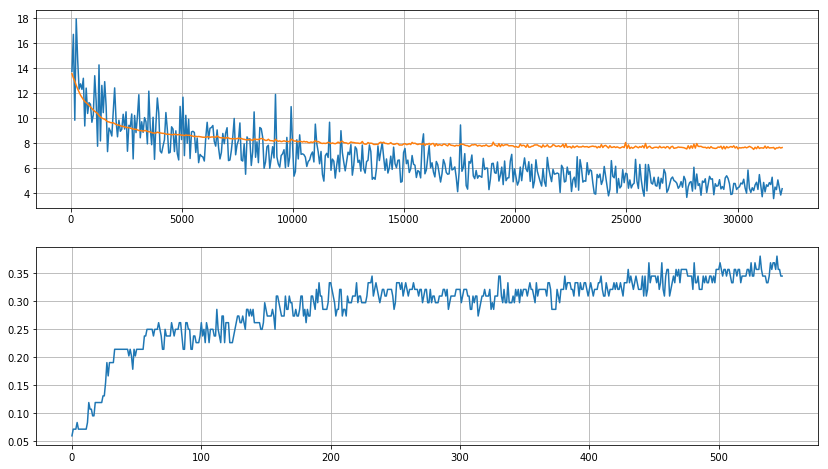

In [4]:
save = False
plot = True

folder = 'results/ff/'
if save:
    if not os.path.exists(folder + '/best_models'):
        os.makedirs(folder + '/best_models')
    
num_models = len(os.listdir(folder)) - 1
hypers_list = dict_of_lists_to_list_of_dicts(hyperparams)
for i, h in enumerate(hypers_list):
    print(f'{i+1} out of {len(hypers_list)}:')
    h['id'] = num_models + i
    train_iteration(h, folder, save=save, plot=plot)

In [4]:
valid_data = SandiaDataProvider(which_set='valid', dataset_home='../../datasets/sandia/', img_size=img_size)
train_data = SandiaDataProvider(which_set='train', dataset_home='../../datasets/sandia/', img_size=img_size)

def measure_acc(data, model, enc):

    tot_q = 0
    tot_correct = 0
    batch_size = 1

    for (inputs, answers), correct_indices in data.get_batch_iterator(batch_size=batch_size,
                                                                           transpose_inputs=True,
                                                                           separate_inputs=True):
        encoded_answers = enc.encode(answers.reshape(-1, img_size ** 2)).reshape(batch_size, -1,
                                                                                 encoding_size)

        correct_answers = answers[range(batch_size), list(correct_indices)]
        encoded_correct = enc.encode(correct_answers.reshape(batch_size, img_size ** 2))
        encoded_correct = Variable(torch.Tensor(encoded_correct), requires_grad=False).cuda()

        # Encode alAdaml inputs in the batch and resape back to batch_size, num_images, encoding_size
        encoded_inputs = enc.encode(inputs.reshape(-1, img_size ** 2))
        encoded_inputs = Variable(torch.Tensor(encoded_inputs.reshape(batch_size, -1, encoding_size)),
                                  requires_grad=False).cuda()

        prediction = model(encoded_inputs)

        sqerr = np.mean((encoded_answers - prediction.cpu().data.numpy()) ** 2, 2)
        # Get the index of the least sq.err for each batch
        choice_indices = sqerr.argmin(1)

        tot_q += len(correct_indices)
        tot_correct += np.sum(correct_indices == choice_indices)

        preds_dec = enc.decode(prediction.view(-1, encoding_size).cpu().data.numpy()).reshape(batch_size, img_size, img_size)
        correct_dec = enc.decode(encoded_correct.cpu().data.numpy()).reshape(batch_size, img_size, img_size)
        
    return tot_correct / tot_q

measure_acc(train_data, best_model, enc)

NameError: name 'img_size' is not defined

In [25]:
measure_acc(valid_data, best_model, enc)

0.40476190476190477

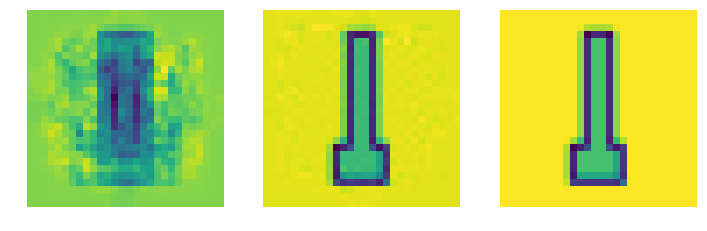

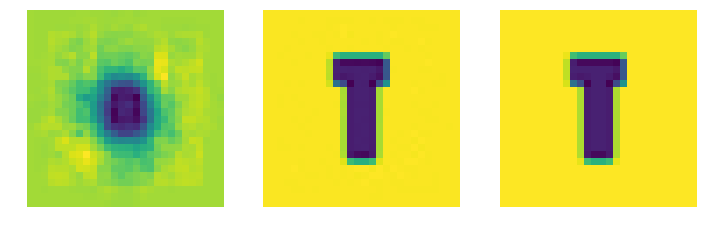

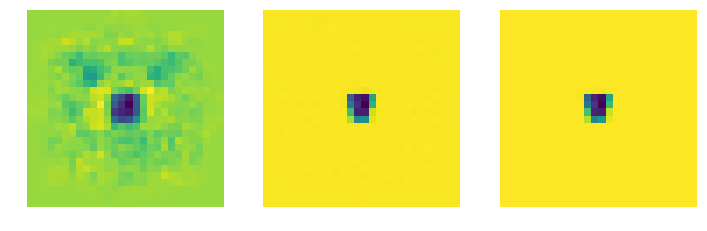

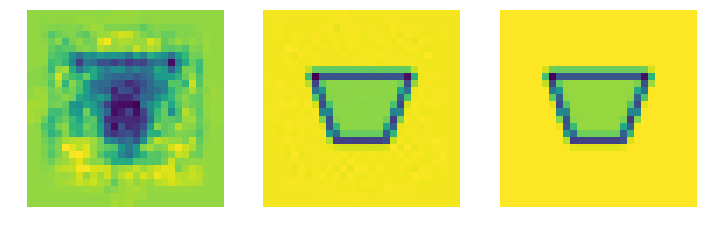

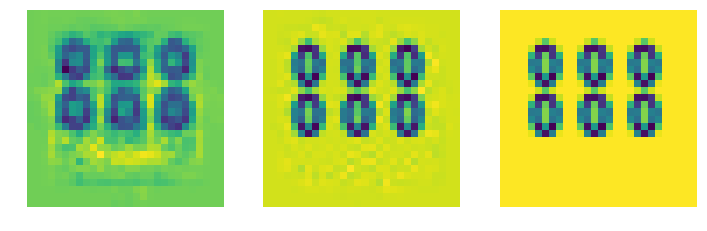

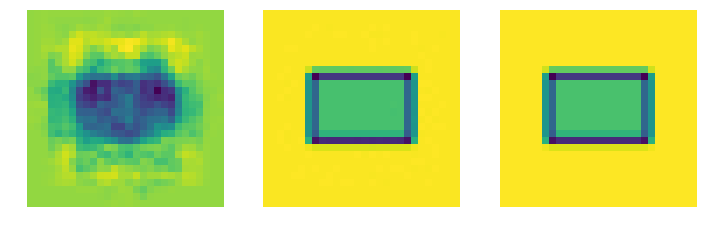

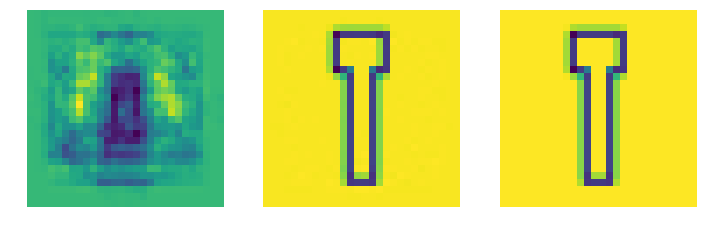

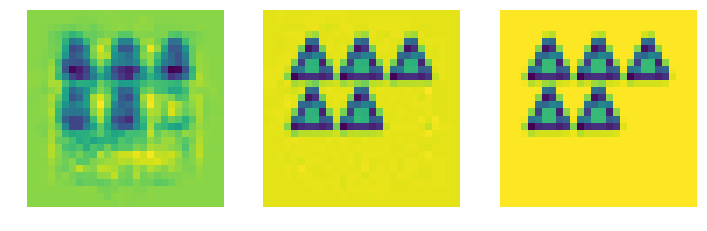

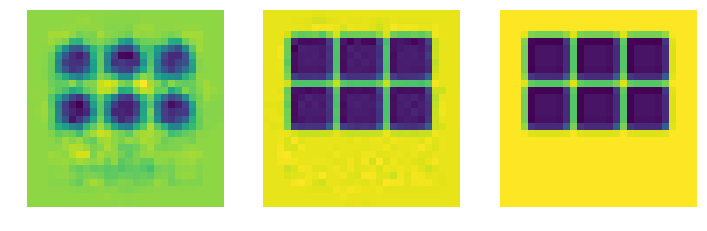

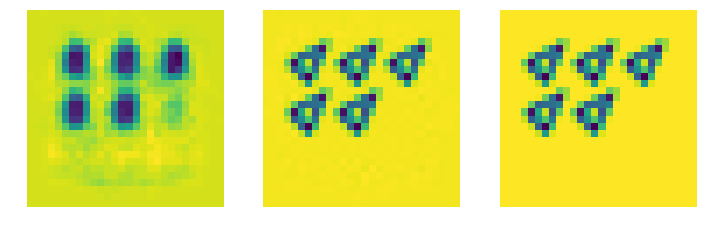

In [135]:
###############################
###### Plot some outputs ######
###############################

batch_size = 10
# test_data = SandiaDataProvider(which_set='valid', dataset_home='../../datasets/sandia/', img_size=img_size)

# Get a batch of validation images
(inputs, answers), correct_indices = next(test_data.get_batch_iterator(batch_size=batch_size,
                                                                       transpose_inputs=True,
                                                                       separate_inputs=True))

correct_answers = answers[range(batch_size), list(correct_indices)]
encoded_correct = enc.encode(correct_answers.reshape(batch_size, img_size ** 2))
encoded_correct = Variable(torch.Tensor(encoded_correct), requires_grad=False).cuda()

# Encode all inputs in the batch and resape back to batch_size, num_images, encoding_size
encoded_inputs = enc.encode(inputs.reshape(-1, img_size ** 2))
encoded_inputs = Variable(torch.Tensor(encoded_inputs.reshape(batch_size, -1, encoding_size)),
                          requires_grad=False).cuda()

prediction = best_model(encoded_inputs)


preds_dec = enc.decode(prediction.view(-1, encoding_size).cpu().data.numpy()).reshape(batch_size, img_size, img_size)
correct_dec = enc.decode(encoded_correct.cpu().data.numpy()).reshape(batch_size, img_size, img_size)

for pred, corr, dec in zip(preds_dec, correct_answers, correct_dec):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')
    
    axs[0].imshow(pred)
    axs[1].imshow(dec)    
    axs[2].imshow(corr)        